In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from infer_utils import get_features, test_single_point

xFormers not available
xFormers not available


In [2]:
args_infer = {
    "model_path" : "runs/bce_grasp_bottle_mask4.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}

device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=args_infer["img_size"])
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"])
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [3]:
max_dist =0
min_dist = 999999
for i in range(4):
    data = dataset[i]
    mask = data["mask"].sum().sqrt()
    all_points = data["points_grasp"]//14
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min():
        min_dist = dif_n.min()

grasp [[666, 572], [660, 545], [588, 561], [594, 589]]
(1, 48, 5)
grasp [[708, 598], [730, 579], [635, 470], [613, 489]]
(1, 55, 5)
grasp [[708, 598], [730, 579], [635, 470], [613, 489]]
(1, 55, 5)
grasp [[684, 630], [688, 601], [549, 579], [544, 608]]
(1, 56, 5)


/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)


In [4]:
test_idx = 0
img, mask, grasp, features, heights, grasp_points = get_features(dataset, model, device, args_infer, test_idx)

org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
mask_n = mask.sum().sqrt()
mask = torch.nn.functional.interpolate(mask.unsqueeze(0), (args_infer["img_size"]//14, args_infer["img_size"]//14), mode="nearest").squeeze()
mask = mask.reshape((args_infer["img_size"]//14)**2)
mask = mask>0

grasp [[666, 572], [660, 545], [588, 561], [594, 589]]
(1, 48, 5)


/home/cedric/anaconda3/envs/4D-humans/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


# Test single point

In [1]:
point_idx = 10
single_point = None 
preds, diff_n, single_point, single_point_gt, height = test_single_point(grasp, mask_n, device, features, model, args_infer, point_idx,heights, single_point=single_point)

NameError: name 'test_single_point' is not defined

In [6]:
th_p = diff_n>max_dist
th_n = diff_n<min_dist
th = th_p + th_n
preds[th] = 0.
preds[mask] = 0.

In [7]:
topk=1
if topk != 0:
    topk, ind = torch.topk(preds, topk)
    preds = torch.zeros(6400)
    preds[ind] = 1
preds = preds.reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)

x, y = ind// (args_infer["img_size"]//14), ind % (args_infer["img_size"]//14)
preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
preds = torch.permute(preds, (1, 0))

In [8]:
pred_point = torch.Tensor([y.item(), x.item()]).to(torch.int64)

In [9]:
def create_oriented_bounding_box(point1, point2, h):
    direction_vector = point2 - point1
    direction_vector /= torch.norm(direction_vector.to(torch.float32))

    perpendicular_vector = torch.tensor([direction_vector[1], -direction_vector[0]])
    scaled_perpendicular_vector = h * perpendicular_vector

    corner_points = torch.stack(
        [
            point1 + scaled_perpendicular_vector,
            point1 - scaled_perpendicular_vector,
            point2 - scaled_perpendicular_vector,
            point2 + scaled_perpendicular_vector,
        ]
    )

    return corner_points

In [10]:
import torch
from shapely.geometry import Polygon

def oriented_bounding_box_iou(box1, box2):
    # Convert tensors to lists
    box1 = box1.tolist()
    box2 = box2.tolist()

    # Create polygons from the corner points
    poly1 = Polygon(box1)
    poly2 = Polygon(box2)

    # Calculate intersection area
    intersection = poly1.intersection(poly2).area

    # Calculate union area
    union = poly1.area + poly2.area - intersection

    # Compute IoU
    iou = intersection / (union + 1e-6)

    return iou


def grasp_correct(pred_point, single_point, single_point_gt,heights,thresh_angle=30,thresh_iou=0.25):
        '''
        given the input point single_point we check if the second point is a valid grasp 
        for that : 
        1) angle difference is less than 30 degress 
        2) the IOU of the points is at least 0.25 
        '''
        
        angle_flag = False
        iou_flag = False
        
        ##1) angle verifier 
        vec_pred_to_single = pred_point - single_point
        vec_single_to_gt = single_point_gt - single_point

        
        dot_product = torch.dot(vec_pred_to_single.to(torch.float64), vec_single_to_gt.to(torch.float64))

        # Calculate the magnitudes of the vectors
        magnitude_pred_to_single = torch.norm(vec_pred_to_single.to(torch.float64))
        magnitude_single_to_gt = torch.norm(vec_single_to_gt.to(torch.float64))

        # Calculate the cosine of the angle between the vectors
        cos_angle = dot_product / (magnitude_pred_to_single * magnitude_single_to_gt)

        # Calculate the angle in radians
        angle_radians = torch.acos(cos_angle)

        # Convert the angle to degrees
        angle_degrees = angle_radians * (180.0 / torch.pi)
        print("angle_degrees", angle_degrees)
        
        if angle_degrees < thresh_angle :        
                angle_flag = True
        
        ##2) IOU verifier, creates 

        corner_points_gt = create_oriented_bounding_box(single_point.to(torch.float32),single_point_gt.to(torch.float32),heights)
        corner_points_pred = create_oriented_bounding_box(single_point.to(torch.float32),pred_point.to(torch.float32),heights)
        iou = oriented_bounding_box_iou(corner_points_gt, corner_points_pred)
        if iou >= thresh_iou:
                iou_flag = True
        
        correct = True if (iou_flag == True )and (angle_flag == True) else False
        print('iou', iou)
        print("Correct", correct)
        return corner_points_gt, corner_points_pred, correct
        
        
        
corner_points, corner_points_pred, correct = grasp_correct(pred_point * 14 + 7, single_point[0,0] * 14 + 7, single_point_gt[0,0] * 14 + 7,data['raw'][point_idx,-1] /2.)




angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.5927731880797058
Correct True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([41, 37])


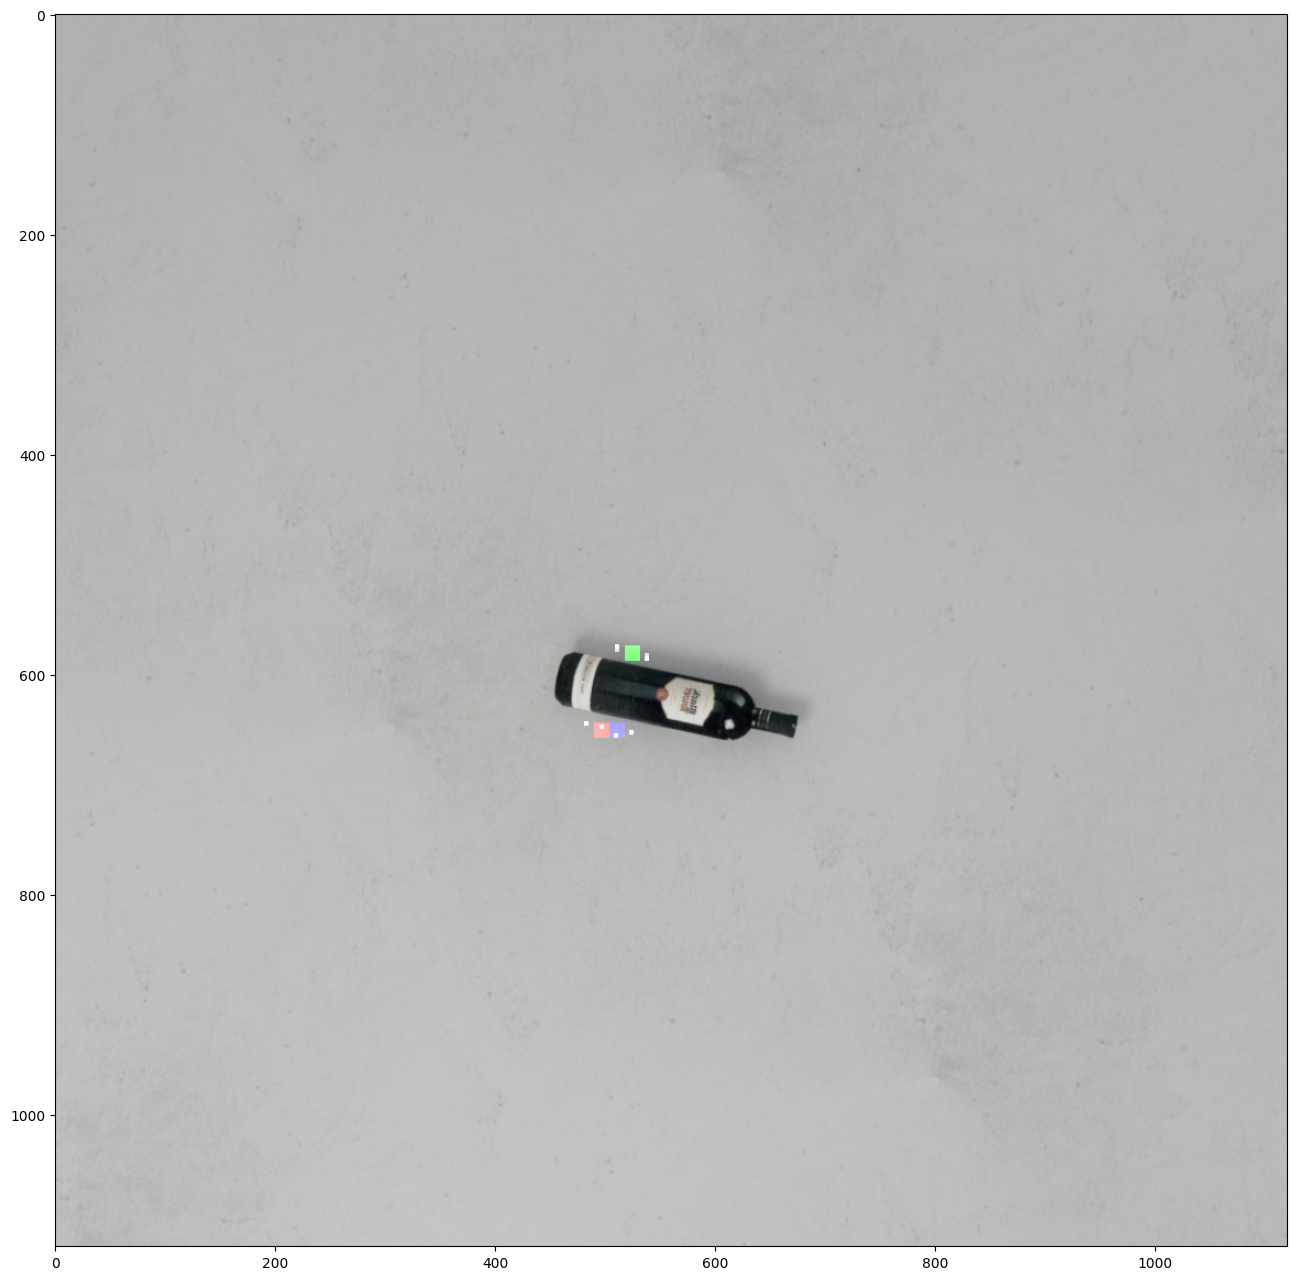

In [11]:
zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 1)
preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
print(single_point[0,0])
origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
origin_point[:, single_point_gt[0][0][0], single_point_gt[0][0][1]] = [0, 0, 1]
#origin_point[:, pred_point[0], pred_point[1]] = [1, 1, 1]
origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
#new_x, new_y = pred_point[0], pred_point[1]
#new_x = single_point[0,0,0] * 14 + 7
#new_y = single_point[0,0,1] * 14 + 7
#boarder = 2
#origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2))
for pt in corner_points : 
    new_x = int(pt[0]) 
    new_y = int(pt[1])
    boarder = 2
    origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2)) * 0.5

for pt in corner_points_pred : 
        new_x = int(pt[0]) 
        new_y = int(pt[1])
        boarder = 2
        origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2)) 



origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

plt.figure(figsize=(16,16))
show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)

### Test for all points

In [13]:
num_all = 0 
num_correct = 0

for point_idx in range(30):   ##test on first 30 points
	single_point = None 
	preds, diff_n, single_point, single_point_gt, height = test_single_point(grasp, mask_n, device, features, model, args_infer, point_idx,heights, single_point=single_point)

	th_p = diff_n>max_dist
	th_n = diff_n<min_dist
	th = th_p + th_n
	preds[th] = 0.
	preds[mask] = 0.

	topk=1
	if topk != 0:
		topk, ind = torch.topk(preds, topk)
		preds = torch.zeros(6400)
		preds[ind] = 1
	preds = preds.reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)

	x, y = ind// (args_infer["img_size"]//14), ind % (args_infer["img_size"]//14)
	preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
	preds = torch.permute(preds, (1, 0))
	pred_point = torch.Tensor([y.item(), x.item()]).to(torch.int64)
	corner_points, corner_points_pred, correct = grasp_correct(pred_point * 14 + 7, single_point[0,0] * 14 + 7, single_point_gt[0,0] * 14 + 7,data['raw'][point_idx,-1] /2.)

	num_correct += correct
	num_all += 1
	zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 1)
	preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
	origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
	print(single_point[0,0])
	origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
	origin_point[:, single_point_gt[0][0][0], single_point_gt[0][0][1]] = [0, 0, 1]
	#origin_point[:, pred_point[0], pred_point[1]] = [1, 1, 1]
	origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
	#new_x, new_y = pred_point[0], pred_point[1]
	#new_x = single_point[0,0,0] * 14 + 7
	#new_y = single_point[0,0,1] * 14 + 7
	#boarder = 2
	#origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2))
	for pt in corner_points : 
		new_x = int(pt[0]) 
		new_y = int(pt[1])
		boarder = 2
		origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2)) * 0.5

	for pt in corner_points_pred : 
		new_x = int(pt[0]) 
		new_y = int(pt[1])
		boarder = 2
		origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2)) 



	origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

	plt.figure(figsize=(16,16))
	show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point
	#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
	plt.title('Correct : ' + str(correct)) 
	plt.imshow(show_img)

print('Total Accuracy', num_correct/num_all * 100, ' %' )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(21.8014, dtype=torch.float64)
iou 0.34744268011273705
Correct True
tensor([42, 41])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(21.8014, dtype=torch.float64)
iou 0.14891329412213627
Correct False
tensor([42, 41])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(21.8014, dtype=torch.float64)
iou 0.49309201146416226
Correct True
tensor([42, 41])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(21.8014, dtype=torch.float64)
iou 0.5721422770750428
Correct True
tensor([42, 41])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(21.8014, dtype=torch.float64)
iou 0.6362356471895693
Correct True
tensor([42, 41])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.5988281304956372
Correct True
tensor([41, 38])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.36132667137963614
Correct True
tensor([41, 38])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.6931878372665109
Correct True
tensor([41, 38])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.7412116337490923
Correct True
tensor([41, 38])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(10.4915, dtype=torch.float64)
iou 0.7797430765462705
Correct True
tensor([41, 38])
